In [112]:
import xarray as xr
import numpy as np
import pylab as plt
import pandas as pd
from datetime import datetime
from scipy.stats import multinomial, binom
from typing import List

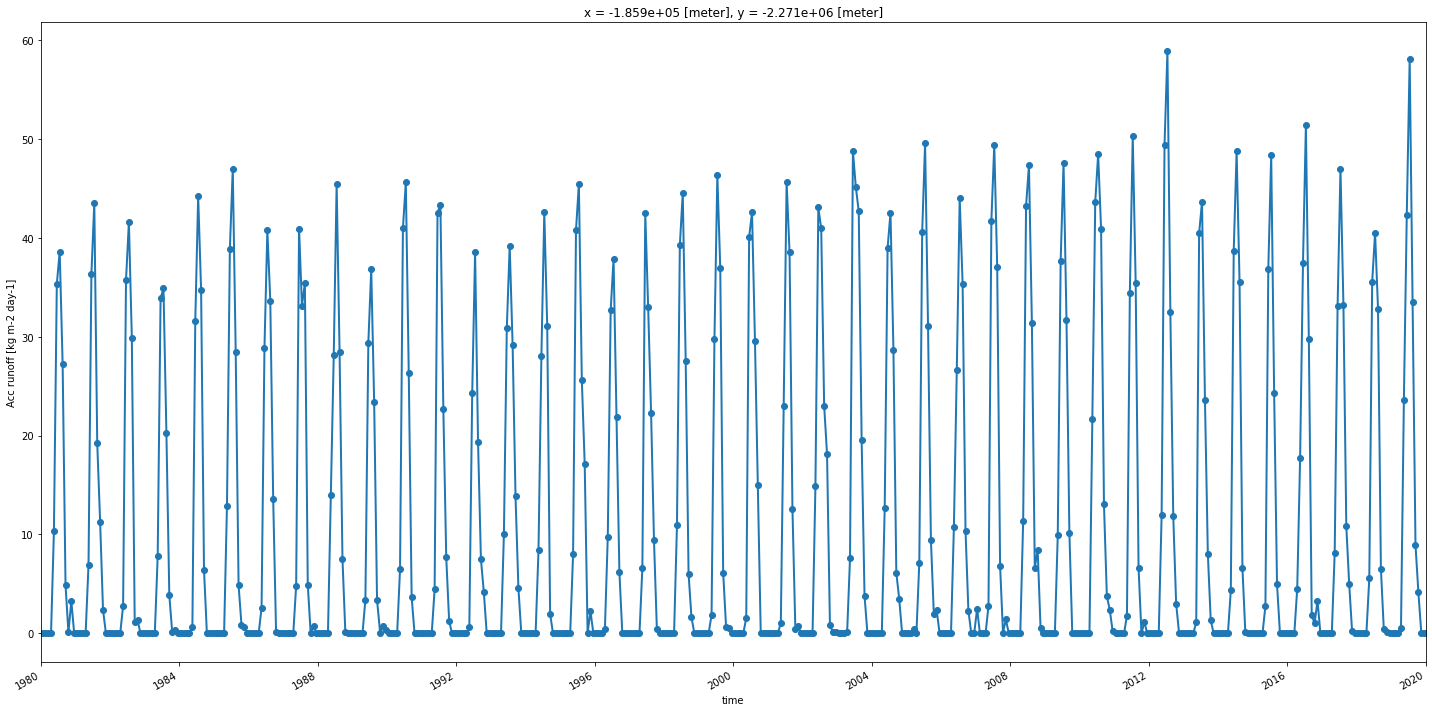

In [111]:
with xr.open_dataset("jib_surface_runoff_DMI-HIRHAM5_ERA_1980_2020_EPSG3413_4500M_MM.nc") as ds:
    time = ds.variables["time"]
    jib = ds.sel(x=[-187924], y=[-2272156.], method="nearest")
    runoff = jib["water_input_rate"]
    runoff.plot(aspect=2, size=10, marker="o", lw=2, xlim=[datetime(1980,1,1), datetime(2020,1,1)])
    plt.tight_layout()
    plt.savefig("jib-runoff-1980-2020.pdf")

## Cumulative yearly runoff

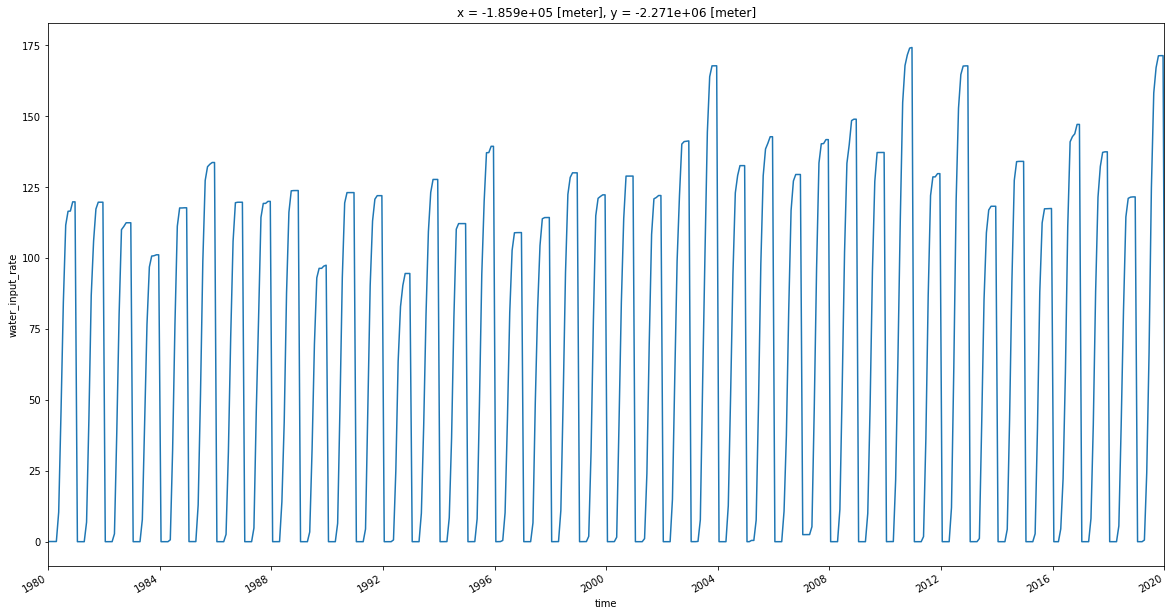

In [110]:
runoff_cysm = runoff.groupby("time.year").apply(lambda x: x.cumsum(dim='time', skipna=True))
runoff_cysm.plot(aspect=2, size=10, xlim=[datetime(1980,1,1), datetime(2020,1,1)])

## Histograms of runoff

(array([202.,  13.,  27.,  10.,  36.,  48., 101.,  38.,  17.]),
 array([  0.        ,  19.44444444,  38.88888889,  58.33333333,
         77.77777778,  97.22222222, 116.66666667, 136.11111111,
        155.55555556, 175.        ]),
 <BarContainer object of 9 artists>)

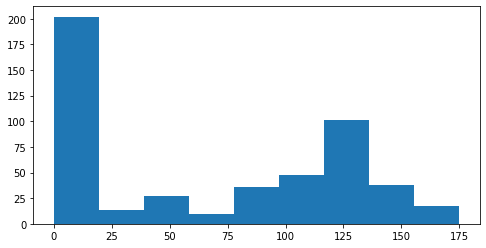

In [59]:
bins = np.linspace(runoff_cysm.values.min(), np.ceil(runoff_cysm.values.max()), 10)
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(111)
ax.hist(runoff_cysm.values.reshape(-1, 1), bins=bins)

In [93]:
def equilibrium_distribution(p_transition):
    """This implementation comes from Colin Carroll, who kindly reviewed the notebook"""
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    # Moore-Penrose pseudoinverse = (A^TA)^{-1}A^T
    pinv = np.linalg.pinv(A)
    # Return last row
    return pinv.T[-1]


def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [62]:
p_init = [0.95, 0.05]
p_transition = np.array([[0.95, 0.05],[0.6, 0.4]])

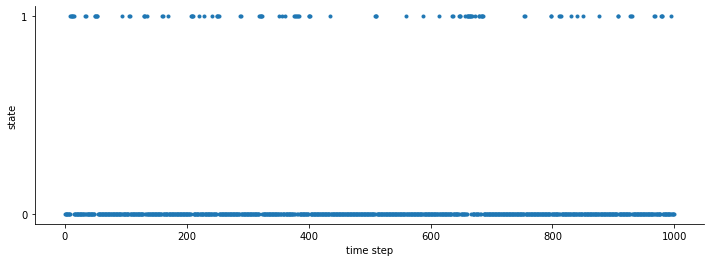

In [68]:
import seaborn as sns
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
    
states = markov_sequence(p_init, p_transition, sequence_length=1000)
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states, ".")
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1])
sns.despine()

In [81]:
# MLE function
# ml modeling and neg LL calculation
def MLE_Norm(parameters):
    # extract parameters
    const, beta, std_dev = parameters
    # predict the output
    # This needs to be a different function
    pred = const + beta*x
    binom.logpmf(y1, m, P)
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.binom.logpdf(y, pred, std_dev))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 


In [82]:
# generate an independent variable 
x = np.linspace(-10, 30, 100)
# generate a normally distributed residual
e = np.random.normal(10, 5, 100)
# generate ground truth
y = 10 + 4*x + e
df = pd.DataFrame({'x':x, 'y':y})
df.head() 

,x,y
0,-10.000000,-13.909865
1,-9.595960,-17.095584
2,-9.191919,-16.347021
3,-8.787879,-13.523163
4,-8.383838,-18.730564


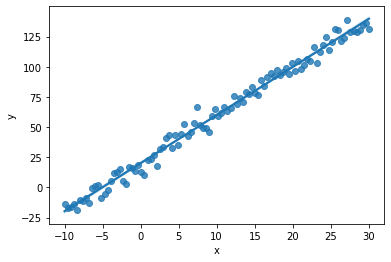

In [83]:
sns.regplot(x='x', y='y', data = df)
plt.show() 

In [87]:
# minimize arguments: function, intial_guess_of_parameters, method
mle_model = minimize(MLE_Norm, np.array([2,2,2]), method='L-BFGS-B')
mle_model 

      fun: 305.7982840537492
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00014211,  0.00546834, -0.00032969])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 128
      nit: 27
     njev: 32
   status: 0
  success: True
        x: array([20.1506372 ,  3.98541596,  5.15020108])

In [89]:
np.exp(-20.1506372)

1.7729212980185572e-09

In [92]:
multinomial?

In [94]:
binom.logpmf?

In [107]:
datetime.strptime("1980-1-1")

TypeError: strptime() takes exactly 2 arguments (1 given)

In [105]:
datetime.strptime?

In [113]:
jib

<xarray.Dataset>
Dimensions:           (time: 492, bnds: 2, y: 1, x: 1)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-16T21:00:00 ... 2020-12-1...
  * x                 (x) float64 -1.859e+05
  * y                 (y) float64 -2.271e+06
Dimensions without coordinates: bnds
Data variables:
    crs               int32 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    water_input_rate  (time, y, x) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 2.0.3 (https://...
    Conventions:               CF-1.6
    history:                   Fri Jul  1 15:40:46 2022: ncks -O -4 -L 2 -d x...
    cdo_openmp_thread_number:  8
    frequency:                 mon
    CDO:                       Climate Data Operators version 2.0.3 (https://...
    NCO:                       netCDF Operators version 5.0.7 (Homepage = htt...